In [1]:
!pip install torcheval --quiet


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
import torch.nn as nn
import torchvision.datasets 
import torchvision.transforms as transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
DEVICE = 'cuda'

In [3]:
prep_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, ), (0.225, ))
])
train_trans = transforms.Compose([
    prep_transform,
    transforms.RandomRotation(20)
])
trainset = torchvision.datasets.MNIST(
    root='./data',
    download=True, 
    train=True, 
    transform=train_trans
)
testset = torchvision.datasets.MNIST(
    root='./data',
    download=True, 
    train=False, 
    transform=prep_transform
)

In [15]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=8)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=8)

In [62]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.seq = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding=1, groups=16),  # Depthwise separable convolutions
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=1),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, groups=64),  # Depthwise separable convolutions
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=1),
            nn.ReLU(),
            
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Conv2d(in_channels=128, out_channels=16, kernel_size=1),
            nn.ReLU(),
            
            nn.Flatten(),
            nn.LayerNorm(576),
            nn.Dropout(0.2),
            nn.Linear(576, 64),
            nn.ReLU(),
            nn.LayerNorm(64),
            nn.Linear(64, 10)
        )
        torch.nn.init.ones_(self.seq[-1].weight)
        torch.nn.init.zeros_(self.seq[-1].bias)
    
    def forward(self, x):
        return self.seq(x)

In [91]:
from torcheval.metrics import MulticlassAccuracy

def run_validation(model, loader):
    model.eval()
    metric = MulticlassAccuracy(num_classes=10)
    with torch.no_grad():
        sum_loss = 0
        for x, y in loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            res = model(x)
            metric.update(torch.argmax(res, dim=-1).cpu(), y.cpu())
            sum_loss += nn.CrossEntropyLoss(reduction='sum')(res, y).item()
    return sum_loss / len(loader.dataset), metric.compute()

In [92]:
def train_model(model, optimizer, epochs, train_loss=None, val_loss=None, val_upds=None, val_acc=None, upd=0):
    if val_upds is None:
        val_upds = []
    if val_acc is None:
        val_acc = []
    if val_loss is None:
        val_loss = []
    if train_loss is None:
        train_loss = []
    loss_fn = nn.CrossEntropyLoss()
    for i in range(epochs):
        for x, y in tqdm(trainloader):
            model.train()
            res = model(x.to(DEVICE))
            loss = loss_fn(res, y.to(DEVICE))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            upd += 1
        #if upd % 500 == 0:
        vloss, vacc = run_validation(model, testloader)
        val_upds.append(upd)
        val_loss.append(vloss)
        val_acc.append(vacc)
    return train_loss, val_loss, val_upds, val_acc, upd

In [78]:
conv_model = ConvNet().to(DEVICE)
optimizer = torch.optim.Adam(conv_model.parameters())
train_loss, val_loss, val_upds, val_acc, upd = [], [], [], [], 0
train_loss, val_loss, val_upds, val_acc, upd = train_model(conv_model, optimizer, 20, train_loss, val_loss, val_upds, val_acc, upd)

100%|██████████| 469/469 [00:20<00:00, 22.95it/s]


In [74]:
def plot_results(train_loss, val_loss, val_upds, val_acc):
    plt.plot(np.arange(len(train_loss)), pd.Series(train_loss).rolling(10).mean(), label='train_loss')
    plt.plot(val_upds, val_loss, label='val_loss')
    plt.legend()
    plt.show()
    plt.plot(val_upds, val_acc)
    plt.show()

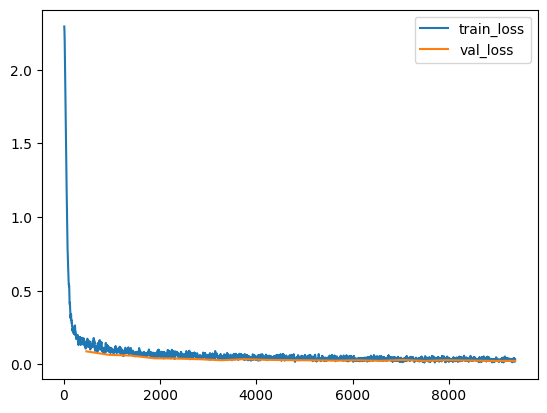

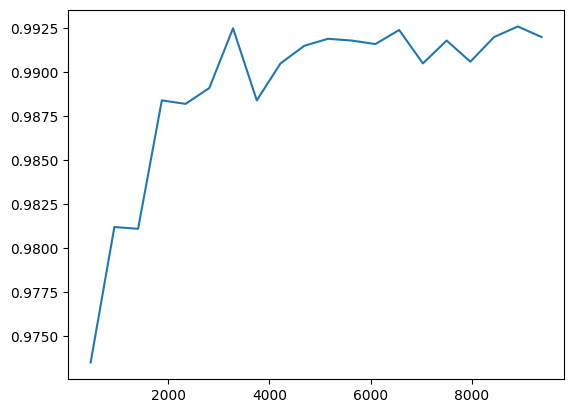

In [79]:
plot_results(train_loss, val_loss, val_upds, val_acc)

In [80]:
print(f'Wrong classification (out of {len(testset)}): {(1 - val_acc[-1].item()) * len(testset)}')

Wrong classification (out of 10000): 80.00016212463379


In [130]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.seq = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Linear(32, 10)
        )
        torch.nn.init.ones_(self.seq[-1].weight)
        torch.nn.init.zeros_(self.seq[-1].bias)
    
    def forward(self, x):
        return self.seq(x)

In [131]:
mlp_model = MLP().to(DEVICE)
optimizer = torch.optim.Adam(mlp_model.parameters())
train_loss, val_loss, val_upds, val_acc, upd = [], [], [], [], 0

In [132]:
train_loss, val_loss, val_upds, val_acc, upd = train_model(mlp_model, optimizer, 40, train_loss, val_loss, val_upds, val_acc, upd)

100%|██████████| 469/469 [00:15<00:00, 30.15it/s]


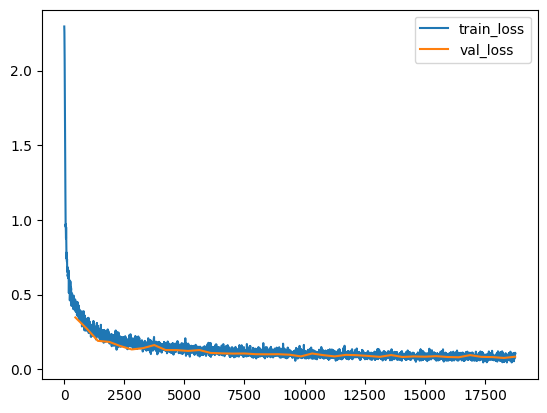

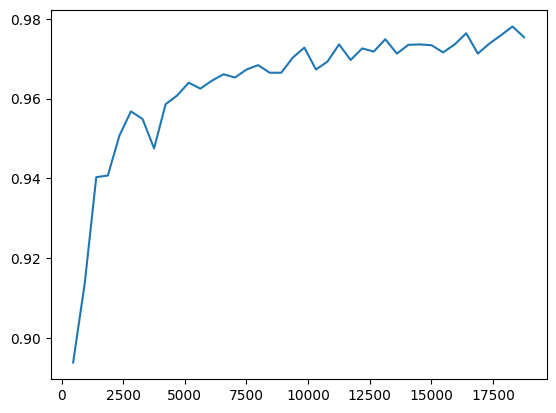

In [133]:
plot_results(train_loss, val_loss, val_upds, val_acc)

In [134]:
print(f'MLP wrong classification (out of {len(testset)}): {(1 - val_acc[-1].item()) * len(testset)}')

MLP wrong classification (out of 10000): 246.0002899169922


In [135]:
mlp_model2 = MLP().to(DEVICE)
optimizer = torch.optim.Adam(mlp_model2.parameters())
train_loss, val_loss, val_upds, val_acc, upd = [], [], [], [], 0

In [136]:
tau = 3
epochs = 40
for i in range(epochs):
    for x, y in tqdm(trainloader):
        x = x.to(DEVICE)
        res = torch.softmax(mlp_model2(x), dim=-1)
        with torch.no_grad():
            yl = torch.softmax(conv_model(x) / tau, dim=-1)
        
        loss = -torch.sum(yl * torch.log(res)) / yl.shape[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        upd += 1
    #if upd % 500 == 0:
    vloss, vacc = run_validation(mlp_model2, testloader)
    val_upds.append(upd)
    val_loss.append(vloss)
    val_acc.append(vacc)

100%|██████████| 469/469 [00:11<00:00, 40.12it/s]


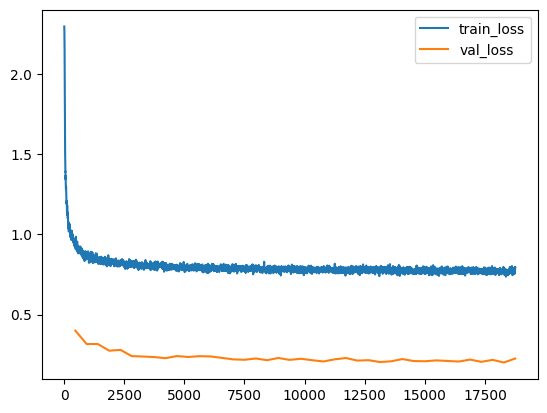

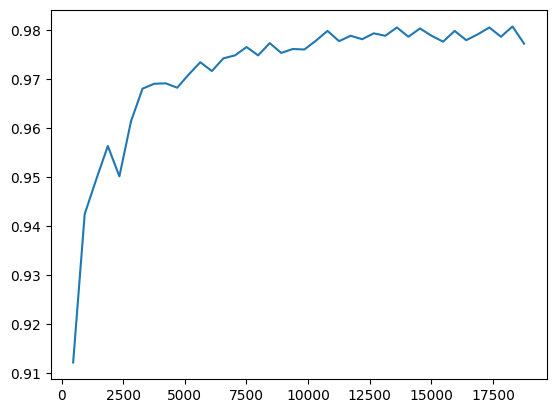

In [137]:
plot_results(train_loss, val_loss, val_upds, val_acc)

In [138]:
print(f'MLP distil wrong classification (out of {len(testset)}): {(1 - val_acc[-1].item()) * len(testset)}')

MLP distil wrong classification (out of 10000): 227.00011730194092
